# Importing  Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [2]:
df=pd.read_csv('/content/intern_screening_dataset.csv')
df.head()

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16406 entries, 0 to 16405
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  16406 non-null  object
 1   answer    16401 non-null  object
dtypes: object(2)
memory usage: 256.5+ KB


As we are having 5 rows of the answer column to be null we can't further preprocess it.Hence we need to remove those entire rows.

In [4]:
df.dropna(subset=['answer'], inplace=True)

# Data Preprocessing

## Data Visualization

In [5]:
df

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl..."
...,...,...
16401,What is (are) Diabetic Neuropathies: The Nerve...,Autonomic neuropathy affects the nerves that c...
16402,What is (are) Diabetic Neuropathies: The Nerve...,"Proximal neuropathy, sometimes called lumbosac..."
16403,What is (are) Diabetic Neuropathies: The Nerve...,Focal neuropathy appears suddenly and affects ...
16404,How to prevent Diabetic Neuropathies: The Nerv...,The best way to prevent neuropathy is to keep ...


# Counting the created Tokens of Q & A
Tokenization is done based on single words usingx.split() method.
* Tokenisation of the text is important as we need to convert the all words into vocabulary, used for feature extraction and improves model performnce.

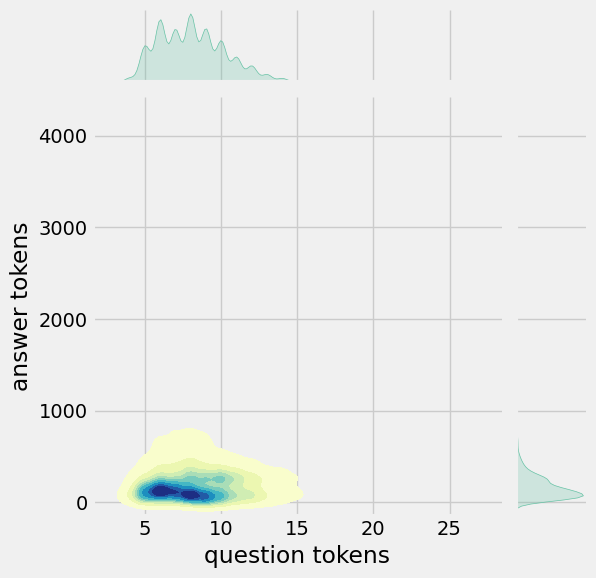

In [7]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda y:len(y.split()))
plt.style.use('fivethirtyeight')
sns.set_palette('Set2')
sns.jointplot(x='question tokens',y='answer tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [8]:
import plotly.express as px
fig = px.histogram(df,
                   x='question tokens',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Question Tokens')
fig.update_layout(bargap=0.1)
fig.show()

In [9]:
import plotly.express as px
fig = px.histogram(df,
                   x='answer tokens',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Answer Tokens')
fig.update_layout(bargap=0.1)
fig.show()

# Text Cleaning
We need to clear the text off any unwanted characters otherwise our model would face hard time to encode/decode.

In [10]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)
df.head()

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl..."


Here we will particularly use the concept of Seq2Seq modelling where the encoder will be fed the data input as question and encoder will pass on the information as a context vector to decoder to predict the output.


In [11]:
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'
df.head()

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,what is (are) glaucoma ?,glaucoma is a group of diseases that can damag...,<start> glaucoma is a group of diseases that c...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...,what is (are) glaucoma ?,the optic nerve is a bundle of more than 1 mil...,<start> the optic nerve is a bundle of more th...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...,what is (are) glaucoma ?,open angle glaucoma is the most common form of...,<start> open angle glaucoma is the most common...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...,<start> anyone can develop glaucoma. some peop...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl...",how to prevent glaucoma ?,"at this time, we do not know how to prevent gl...","<start> at this time, we do not know how to pr..."


**Note that here we will be use the TEACHER FORCING Method to reduce the limitation of Encoder having errors in transfering of data.**

**The decoder model will not recieve the output of the encoder but the correct input that we will be giving so that it could be fed correct data for prediction.**



In [12]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))

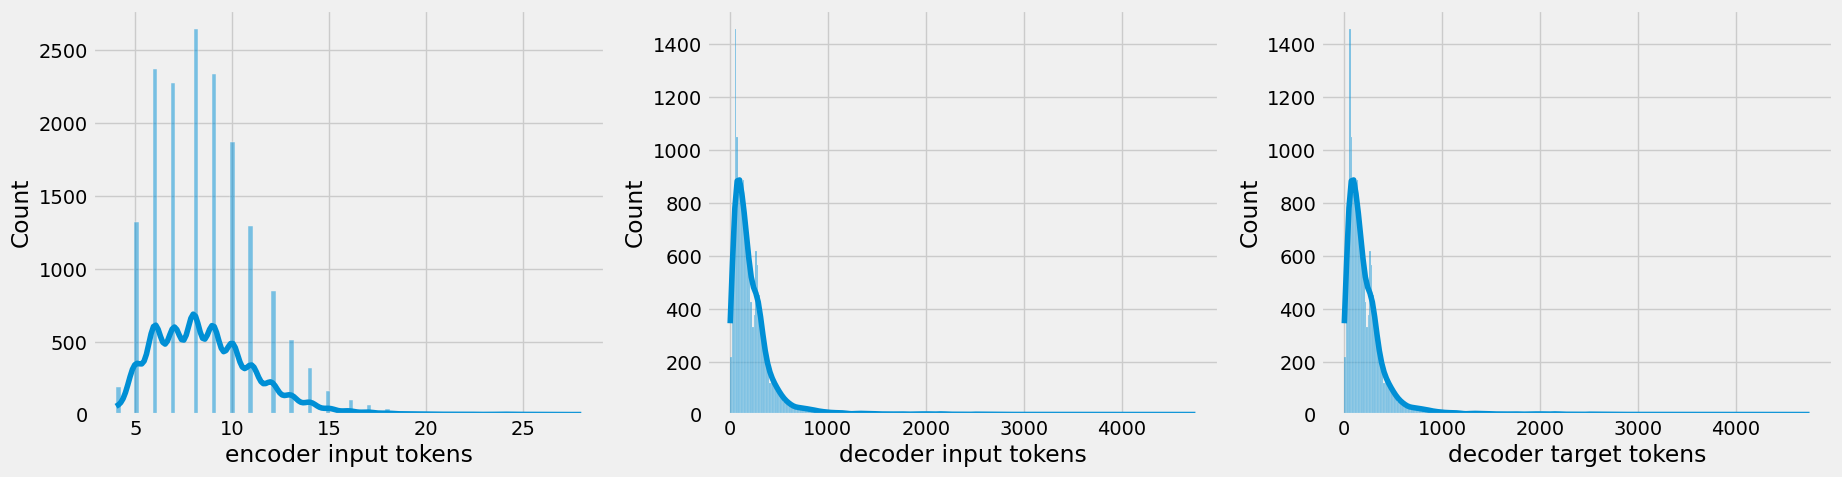

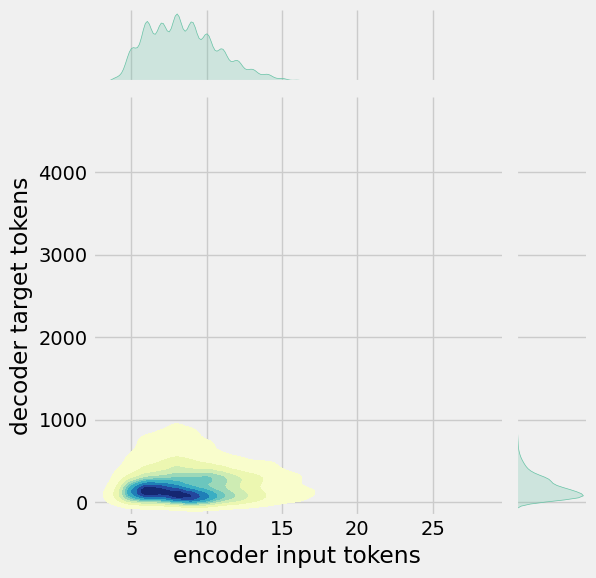

In [9]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [13]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)

df.head(10)

After preprocessing: what research (or clinical trials) is being done for national hormone and pituitary program (nhpp): information for people treated with pituitary human growth hormone (comprehensive report) ?
Max encoder input length: 27
Max decoder input length: 4238
Max decoder target length: 4237


,encoder_inputs,decoder_targets,decoder_inputs
0,what is (are) glaucoma ?,glaucoma is a group of diseases that can damag...,<start> glaucoma is a group of diseases that c...
1,what is (are) glaucoma ?,the optic nerve is a bundle of more than 1 mil...,<start> the optic nerve is a bundle of more th...
2,what is (are) glaucoma ?,open angle glaucoma is the most common form of...,<start> open angle glaucoma is the most common...
3,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...,<start> anyone can develop glaucoma. some peop...
4,how to prevent glaucoma ?,"at this time, we do not know how to prevent gl...","<start> at this time, we do not know how to pr..."
5,what are the symptoms of glaucoma ?,"at first, open angle glaucoma has no symptoms....","<start> at first, open angle glaucoma has no s..."
6,what are the treatments for glaucoma ?,"yes. immediate treatment for early stage, open...",<start> yes. immediate treatment for early sta...
7,what research (or clinical trials) is being do...,through studies in the laboratory and with pat...,<start> through studies in the laboratory and ...
8,who is at risk for glaucoma? ?,encourage them to have a comprehensive dilated...,<start> encourage them to have a comprehensive...
9,what is (are) glaucoma ?,national eye institute national institutes of...,<start> national eye institute national insti...


### Some Information about the parameters that we need to define

##### Buffer size:This is the number of elements from which the new dataset will be sampled.
##### vocab_size:This is the size of the vocabulary, i.e., the number of unique tokens (words or characters) in your dataset. Each token will be assigned a unique integer index ranging from 0 to vocab_size - 1
##### max_sequence_length:Depends on the max length of answer that we want our model to predict.
##### lstm_cells and embedding_dim: As seen from the diagram it is the number of lstm cells that are sequentially arranged in our encoder model.


In [14]:
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']

## Tokenization

In [11]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2500
['', '[UNK]', 'the', '.', ',', 'of', 'and', 'a', 'in', 'is', 'to', 'or']


Here we have created a Vectorisation layer that converts tokens(words) to vectors so that computer could understand.
### To encode the words to ids we use sequence2ids function while the vice versa can be done by ids2sequences function
###### Note that vectorize_layer.adapt() is used to pass on the vocabulary of words that we have into the vectorisation layer

In [12]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [ 1  4 50 12 47 24  0  0  0  0]
Encoder input shape: (16401, 30)
Decoder input shape: (16401, 30)
Decoder target shape: (16401, 30)


**Here the x,yd,y are the vectorised form of tokens where x will be input to encoder,yd will be input to decoder using teacher forcing and y is the decoder true output.**

In [13]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [  29    9  133 1354   24    0    0    0    0    0    0    0] ...
Decoder input: [  28 1354    9    7  180    5  310   15   26  289    2  232] ...
Decoder target: [1354    9    7  180    5  310   15   26  289    2  232   69] ...


#### Below are the explanation of some of the methods used ahead for preprocessing of the train data:
* The cache() method caches the dataset in memory or on disk, which speeds up subsequent epochs by avoiding the cost of reading from disk repeatedly. If the dataset fits in memory, this can significantly improve training speed.
* The shuffle(buffer_size) method randomly shuffles the elements of the dataset to ensure that the training data is well-mixed, which helps in reducing model overfitting.buffer_size determines the number of elements from the dataset that the shuffle operation will buffer. A larger buffer size means better shuffling but requires more memory.
* The batch(batch_size) method combines consecutive elements of the dataset into batches of the specified size.
* The prefetch(tf.data.AUTOTUNE) method overlaps the preprocessing and model execution of data. It allows the data pipeline to fetch the next batch of data while the current batch is being processed by the model, thus improving the efficiency and throughput.
* The as_numpy_iterator() method converts the dataset into an iterator that yields elements as NumPy arrays. This can be useful for inspection or debugging, allowing you to iterate through the dataset and inspect the data in a familiar format (NumPy arrays).

In [14]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 100
Number of training data: 14900
Number of validation batches: 12
Number of validation data: 1788
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


We can get the slices of array by using from_tensor_slices() method to pass our input data and then proceeding further to shuffle the data.

# Build Models

## Build Encoder

# Creating an Encoder class

In [15]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )

    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.02905541,  0.06772265,  0.14788112, ..., -0.01863714,
          0.03360803,  0.29537436],
        [ 0.1245693 , -0.03238191,  0.2161501 , ..., -0.20612204,
         -0.04285522, -0.05794118],
        [ 0.09375532,  0.10222144,  0.2332835 , ..., -0.12017962,
         -0.10708494,  0.21482594],
        ...,
        [ 0.19211243,  0.04376101,  0.23446728, ...,  0.08098157,
         -0.05555901,  0.24576975],
        [ 0.22617371,  0.03149453,  0.336982  , ...,  0.05063849,
         -0.18375644, -0.05866833],
        [ 0.04156113,  0.09189   ,  0.26705518, ...,  0.07366493,
          0.06593917, -0.06309695]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.04385017,  0.18972906,  0.27526084, ..., -0.0517998 ,
          0.06923752,  0.5901342 ],
        [ 0.1842296 , -0.08375166,  0.42068163, ..., -0.5807267 ,
         -0.08526431, -0.11058751],
        [ 0.13756688,  0.2979048 ,  0.43387523,

### High level overview of the Encoder model that we have created:-
* The __init__ method initializes the encoder with the specified units (number of LSTM units), embedding_dim (dimension of the embedding vectors), and vocab_size (size of the vocabulary).
* *args and ***kwargs allow for additional arguments and keyword arguments to be passed to the parent class's __init__ method.It can be kept undeclared while calling the parent class.
* After defining the units,vocab_size,embedding_dim .
## We can define the embedding layer.
* The Embedding layer in Keras is used to convert positive integer indices into dense vectors of fixed size.It converts words or tokens to indices representation.
* mask_zero=True :means it adds zero values to shorter sentences as paddings to ensure uniform length and those zero values sould be ignored while training.
* Initializes the embedding vectors using the Glorot Normal initializer to help with effective training.
* Normalised the embedding layer vector hence produced.
## After that we create an LSTM with the following parameters:-
* Number of Units: Each LSTM cell has units number of LSTM units.
* Dropout: A dropout rate of 40% is applied to the inputs of the LSTM cells during training to prevent overfitting.
* Return States: The layer returns the last hidden state (h) and the last cell state (c) in addition to the output sequences.
* Return Sequences: The layer returns the full sequence of outputs for each input sequence.
* Kernel Initializer: The LSTM weights are initialized using the Glorot Normal initializer.
## Defining the call function
1.  The input sequences (encoder_inputs) are passed through the embedding layer, converting the integer token indices into dense vectors of size embedding_dim.X is now a tensor with shape (batch_size, sequence_length, embedding_dim).
2.  The embedded sequences are passed through a layer normalization layer.
Layer normalization helps stabilize and accelerate the training process by normalizing the inputs across the features (embeddings) dimension.
3.  A dropout layer with a dropout rate of 0.4 is applied to the normalized embeddings.
4.  The processed embeddings x are passed through the LSTM layer.
####The LSTM layer returns three values:
   * encoder_outputs: The full sequence of outputs from the LSTM for each time step, with shape (batch_size, sequence_length, units).
   * encoder_state_h: The final hidden state of the LSTM, with shape (batch_size, units).
   * encoder_state_c: The final cell state of the LSTM, with shape (batch_size, units).
### _[0]: This represents the input data being passed to the call method. It is iterator to the batch of data tensor with shape (batch_size, sequence_length), where batch_size is the number of sequences in the batch, and sequence_length is the length of each sequence. Each element in the sequence is an integer token index.

# Build Decoder

In [16]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )

    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2500), dtype=float32, numpy=
array([[[4.6826978e-04, 7.0965337e-04, 8.9921588e-05, ...,
         6.3904423e-05, 5.0832256e-04, 4.4564051e-03],
        [5.6018383e-04, 1.3974705e-04, 4.1128209e-04, ...,
         1.1277213e-04, 3.1326094e-04, 2.1246562e-03],
        [9.4280799e-04, 2.6326097e-04, 1.6374532e-04, ...,
         1.2878579e-04, 3.6393667e-05, 1.4983215e-03],
        ...,
        [3.7376038e-05, 8.0382881e-05, 6.1156592e-05, ...,
         1.6462852e-04, 5.0305847e-05, 5.9933279e-04],
        [1.0475056e-04, 1.5285672e-04, 7.9282087e-05, ...,
         4.0302909e-04, 6.2058622e-05, 2.2188248e-03],
        [1.3337909e-04, 1.5523782e-04, 6.2340952e-04, ...,
         2.5596036e-04, 1.5862739e-05, 1.3132645e-03]]], dtype=float32)>

# High Level overview of DECODER CLASS:-
Apart from the variables having objects than encoder lets pick up some new object that are not been covered.
#### self.fc:Assigns the initialized dense layer to the attribute fc of the class instance
* Softmax activation function normalizes the output vector into a probability distribution over the target classes (in this case, vocabulary tokens). It's commonly used for multi-class classification tasks.
* HeNormal initializer initializes the weights with values drawn from a truncated normal distribution centered on 0 with a standard deviation proportional to the square root of the number of units in the previous layer.
### The call method defines the forward pass of the decoder:

1.  Embedding: Convert token indices to dense vectors.
2.  Normalization and Dropout: Normalize and apply dropout to the embedded sequences.
3. LSTM: Process the sequences through the LSTM layer, using the final states of the encoder as initial states.
4. Additional Normalization and Dropout: Normalize and apply dropout to the LSTM output.
5. Dense Layer: Produce logits for the next token in the vocabulary.

## Build Training Model

In [17]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)

    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics

    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

## High level overview of how we created the overall model of our chatbot.
* After passing the encoder and decoder class to ur parent chatbot trainer class.
### We defined our **Custom Loss Function** that we want to minimise upon the sucessive iteration.
* It takes three arguments:
 * self: The instance of the class (assuming this method belongs to a class).
 * y_true: The true labels.
 * y_pred: The predicted labels.
* self.loss computes the loss using the predefined loss function self.loss(Ahead it is defined as sparsed categorical cross entropy loss).
#### A **mask function** is created to identify the positions of padding tokens (where y_true is equal to 0).
1. tf.math.equal(y_true, 0) creates a boolean mask where True indicates the positions of padding tokens.
2. .math.logical_not flips the boolean values so that True indicates the positions of non-padding tokens.
3. tf.cast(mask, dtype=loss.dtype) casts the boolean mask to the same data type as the loss tensor.
4. The loss tensor is then multiplied element-wise by the mask, effectively setting the loss to 0 at the positions of padding tokens.
**This custom loss function ensures that padding tokens do not contribute to the computed loss.**
## Then we can move onto the accuracy instance where:-
1. tf.argmax(y_pred, axis=-1) computes the index of the maximum value along the last axis of y_pred, which represents the predicted class for each sample the computed value is converted to int64 using the cast function.
2. tf.equal(y_true, pred_values) compares the true labels (y_true) with the predicted labels (pred_values) element-wise.
The result is a boolean tensor where True indicates correct predictions and False indicates incorrect predictions.The result is stored in float64 using cast function.
3. tf.greater(y_true, 0) creates a boolean mask where True indicates non-padding tokens (since padding tokens are assumed to be represented by 0).
4. **Counting Correct Predictions** :-
  * mask * correct performs element-wise multiplication between the mask and the correct predictions tensor. This effectively masks out the correct predictions corresponding to padding tokens.
  * tf.keras.backend.sum(...) computes the sum of the resulting tensor, effectively counting the number of correct predictions for non-padding tokens.
**Computing Accuracy**:: n_correct / n_total
## Call instance :-
* The inputs tuple is unpacked into encoder_inputs and decoder_inputs.
* encoder_inputs are passed through the encoder model (self.encoder).
That produces the final states of the encoder LSTM, which are then used as initial states for the decoder LSTM.
* decoder_inputs and encoder_states are passed to the decoder model (self.decoder).
Hence call instance does:
1. Encoder inputs are passed through the encoder to produce encoder states.
2. Decoder inputs and encoder states are passed to the decoder to generate output sequences.
# Next we define the training steps to be followed:-
* Batch: A batch of training data, containing encoder inputs, decoder inputs, and corresponding target sequences (y).
* Then we use GradientTape which tracks operations for automatic differentiation si that we can use it to differentiate our loss function to optimise the weights using the gradient descent.
* The gradients of the loss with respect to the trainable variables of both the encoder and decoder are computed using the gradient tape.
* Metrics such as loss and accuracy are collected for monitoring the training process and at last all the metrics are returned.
## Next we define the testing steps to be followed:-
* Encoder inputs are passed through the encoder model (self.encoder) to obtain the encoder states.
* The encoder states and decoder inputs are passed through the decoder model (self.decoder) to obtain the predicted outputs (y_pred).
* **Loss Calculation** :The loss is computed using the provided loss function (self.loss_fn), comparing the predicted outputs (y_pred) with the true target sequences (y).
* **Accuracy Calculation**:The accuracy is computed using the provided accuracy function (self.accuracy_fn), which compares the predicted outputs (y_pred) with the true target sequences (y).
* **Metrics Calculation**:Metrics such as loss and accuracy are collected for monitoring the testing or evaluation process at last the metrics are returned.



In [18]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2500), dtype=float32, numpy=
array([[[4.68269805e-04, 7.09654065e-04, 8.99216539e-05, ...,
         6.39044665e-05, 5.08322497e-04, 4.45641484e-03],
        [5.60183777e-04, 1.39747019e-04, 4.11281828e-04, ...,
         1.12772061e-04, 3.13260971e-04, 2.12465646e-03],
        [9.42808809e-04, 2.63261230e-04, 1.63745412e-04, ...,
         1.28785599e-04, 3.63936815e-05, 1.49832270e-03],
        ...,
        [3.73760195e-05, 8.03828661e-05, 6.11566065e-05, ...,
         1.64628582e-04, 5.03059127e-05, 5.99333260e-04],
        [1.04750448e-04, 1.52856795e-04, 7.92820429e-05, ...,
         4.03029437e-04, 6.20586143e-05, 2.21882574e-03],
        [1.33379013e-04, 1.55237823e-04, 6.23410509e-04, ...,
         2.55960302e-04, 1.58627608e-05, 1.31326495e-03]],

       [[4.26324434e-04, 2.54158775e-04, 1.09286746e-04, ...,
         4.30934524e-05, 3.79111210e-04, 1.26090669e-03],
        [6.61386526e-04, 5.75590057e-05, 1.19643359e-04, ...,
         4.22938931e-04, 1

## After that we compiled our model using the above parameters and obtained our model with applied optimisers.

##  Train Model

In [21]:
history=model.fit(
    train_data,
    epochs=11,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/11
100/100 [==============================] - ETA: 0s - loss: 2.0056 - accuracy: 0.5570
Epoch 1: val_loss improved from inf to 1.59120, saving model to ckpt


100/100 [==============================] - 27s 259ms/step - loss: 2.0111 - accuracy: 0.5561 - val_loss: 1.5912 - val_accuracy: 0.6000
Epoch 2/11
100/100 [==============================] - ETA: 0s - loss: 1.9926 - accuracy: 0.5585
Epoch 2: val_loss improved from 1.59120 to 1.58080, saving model to ckpt


100/100 [==============================] - 21s 209ms/step - loss: 1.9912 - accuracy: 0.5588 - val_loss: 1.5808 - val_accuracy: 0.6333
Epoch 3/11
100/100 [==============================] - ETA: 0s - loss: 1.9707 - accuracy: 0.5627
Epoch 3: val_loss improved from 1.58080 to 0.62970, saving model to ckpt


100/100 [==============================] - 22s 221ms/step - loss: 1.9608 - accuracy: 0.5649 - val_loss: 0.6297 - val_accuracy: 0.8333
Epoch 4/11
100/100 [==============================] - ETA: 0s - loss: 1.9600 - accuracy: 0.5638
Epoch 4: val_loss did not improve from 0.62970
100/100 [==============================] - 4s 36ms/step - loss: 1.9560 - accuracy: 0.5647 - val_loss: 1.7483 - val_accuracy: 0.6000
Epoch 5/11
100/100 [==============================] - ETA: 0s - loss: 1.9565 - accuracy: 0.5635
Epoch 5: val_loss improved from 0.62970 to 0.04822, saving model to ckpt


100/100 [==============================] - 23s 236ms/step - loss: 1.9605 - accuracy: 0.5627 - val_loss: 0.0482 - val_accuracy: 1.0000
Epoch 6/11
 99/100 [============================>.] - ETA: 0s - loss: 1.9510 - accuracy: 0.5633
Epoch 6: val_loss did not improve from 0.04822
100/100 [==============================] - 3s 34ms/step - loss: 1.9666 - accuracy: 0.5609 - val_loss: 1.6585 - val_accuracy: 0.6333
Epoch 7/11
100/100 [==============================] - ETA: 0s - loss: 1.9479 - accuracy: 0.5642
Epoch 7: val_loss did not improve from 0.04822
100/100 [==============================] - 4s 41ms/step - loss: 1.9537 - accuracy: 0.5634 - val_loss: 3.3778 - val_accuracy: 0.4333
Epoch 8/11
 98/100 [============================>.] - ETA: 0s - loss: 1.9331 - accuracy: 0.5658
Epoch 8: val_loss did not improve from 0.04822
100/100 [==============================] - 3s 34ms/step - loss: 1.9312 - accuracy: 0.5664 - val_loss: 3.9631 - val_accuracy: 0.2667
Epoch 9/11
100/100 [=====================

1. **The tf.keras.callbacks.TensorBoard callback is used to log training and validation metrics during the training of a TensorFlow model. It is used so that we can see TensorBoard visualization tool, which allows you to visualize these metrics in real-time as your model trains.**
2. **The tf.keras.callbacks.ModelCheckpoint callback is used to save the model's weights during training. It allows you to save the model either after every epoch or only when certain conditions are met, such as when the validation loss improves.**
3. Note that i have set this epochs to 11 as val_accuracy was not improving so more epochs were a waste of computational resources.

#  Visualize Metrics

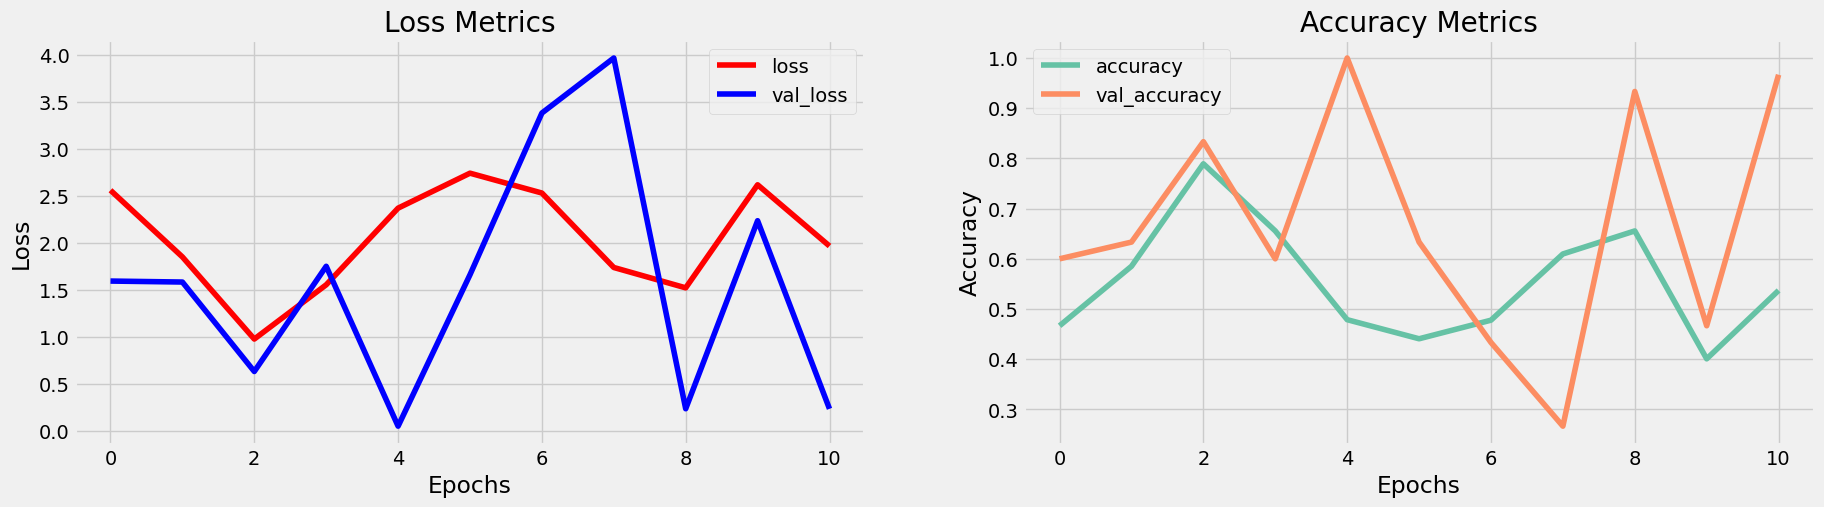

In [22]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [23]:
history.history['accuracy']

[0.4666666666666667,
 0.5851851851851851,
 0.789272030651341,
 0.6555555555555556,
 0.47876447876447875,
 0.44074074074074077,
 0.4777777777777778,
 0.6096654275092936,
 0.6555555555555556,
 0.4008097165991903,
 0.5370370370370371]

Above is the accuracy of our model with given epoch ranging from 0 to 10.

# Save Model
### Saving the best model

In [24]:
model.load_weights('ckpt')
model.save('models',save_format='tf')

We have saved the best model out of all epochs the model has been trained.

In [25]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


Above is the overall stucture of our encoder/decoder model.

# Create Inference Model

## Combining everythng into a single chatbot class what we have done above.

In [26]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq

    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, None, 256)         640000    
 ng)                                                             
                                                                 
 layer_normalization (Layer  (None, None, 256)         512       
 Normalization)                                                  
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1165824 (4.45 MB)
Trainable params: 1

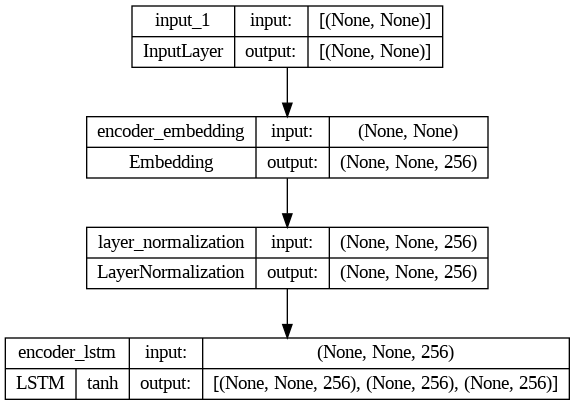

In [27]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

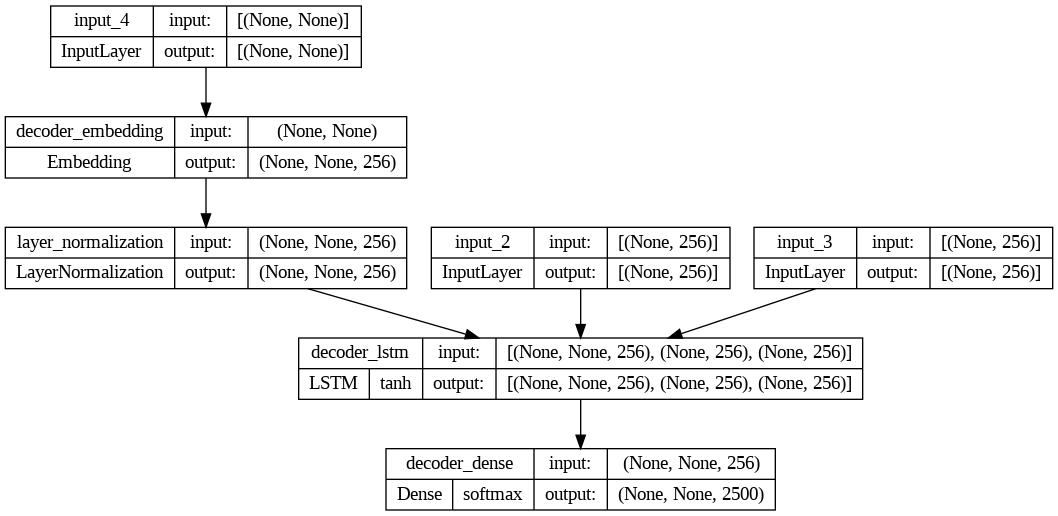

In [28]:
tf.keras.utils.plot_model(chatbot.decoder,to_file='decoder.png',show_shapes=True,show_layer_activations=True)

# Time to Chat

In [41]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')


In [39]:
print_conversation([
    "What is (are) Glaucoma ?"
])

You: What is (are) Glaucoma ?
Bot: glaucoma is a heart disease that affects the heart, the heart's normal rhythm. the heart is a [unk] of blood vessels. the heart is a 


In [42]:
print_conversation([
    "How to diagnose Diabetic Neuropathies: The Nerve Damage of Diabetes "
])

You: How to diagnose Diabetic Neuropathies: The Nerve Damage of Diabetes 
Bot: your doctor will diagnose [unk] based on your medical history, a physical exam, and test results. specialists involved in your blood, your doctor will ask your 


In [45]:
print_conversation([
    "what is Diabetes?"
])

You: what is Diabetes?
Bot: diabetes is a complex group of conditions that causes [unk] [unk] [unk] [unk] [unk] [unk]. the [unk] of the [unk] [unk] [unk], [unk], [unk], [unk], 


In [57]:
print_conversation([
    "What are the symptoms of Breast Cancer ?"
])

You: What are the symptoms of Breast Cancer ?
Bot: signs of breast cancer include jaundice, and easy bruising or bleeding. the signs and symptoms of [unk] include [unk] pain, and feeling tired. these and other 


In [60]:
print_conversation([
    "what is Osteoporosis ?"
])

You: what is Osteoporosis ?
Bot: [unk] is a problem that affects the bones. it is a [unk] of the skin, or [unk]. it is a chronic [unk] skin that is present from 


In [ ]:
print_conversation([
    "what is Osteoporosis ?"
])